In [1]:
# downloading the dataset
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [3]:
# loading the dataset
datadir = 'track'
names=['center', 'left', 'right', 'steering_angle', 'column x', 'column_y', 'column_z']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=names)
data.head()

,center,left,right,steering_angle,column x,column_y,column_z
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [4]:
# path simplification of the images in the csv file
def path_simplify(path):
  path_head, path_tail = ntpath.split(path)
  return path_tail

data['center'] = data['center'].apply(path_simplify)
data['left'] = data['left'].apply(path_simplify)
data['right'] = data['right'].apply(path_simplify)
data.head()

,center,left,right,steering_angle,column x,column_y,column_z
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


# **Data Preprocessing**

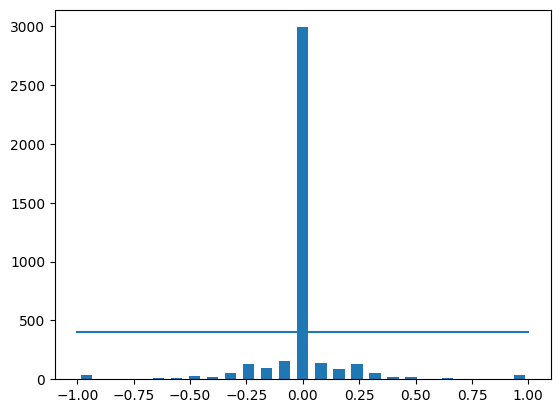

In [5]:
# getting the histogram of steering angle count
bin_count = 25
samples_bins = 400
hist, bins = np.histogram(data['steering_angle'], bin_count)
center_bar = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center_bar, hist, width=0.05)

# drawing a threshold line
plt.plot((np.min(data['steering_angle']), np.max(data['steering_angle'])), (samples_bins, samples_bins))

In [6]:
# making histogram more noirmalized by applying threshodling
removed_items = []

for j in range(bin_count):
  index_list = []
  for i in range(len(data['steering_angle'])):
    if data['steering_angle'][i] >= bins[j] and data['steering_angle'][i] <= bins[j+1]:
      index_list.append(i)

  shuffled_list = shuffle(index_list)
  index_list = shuffled_list[samples_bins:]
  removed_items.extend(index_list)


print('removed:', len(removed_items))
data.drop(data.index[removed_items], inplace=True)
print('remaining:', len(data))

removed: 2590
remaining: 1463


<BarContainer object of 25 artists>

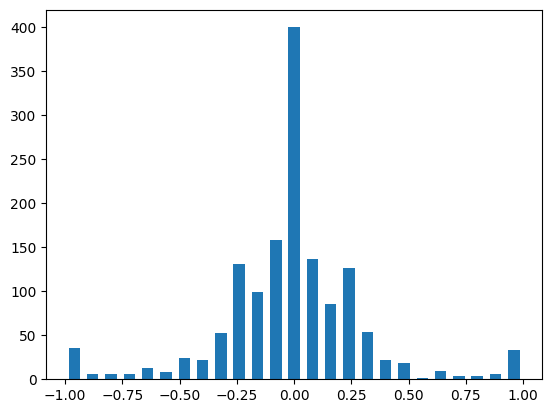

In [7]:
# replot the normalized histogram
hist, _ = np.histogram(data['steering_angle'], (bin_count))
plt.bar(center_bar, hist, width=0.05)

In [8]:
# creating a single dataset by adding image paths and relavant steering angles
def load_img_steering_angle(datadir, data):
  image_paths = []
  steering_angles = []

  for i in range(len(data)):
    indexes = data.iloc[i]
    center_image, left_image, right_image = indexes[0], indexes[1], indexes[2]

    image_paths.append(os.path.join(datadir, center_image.strip()))
    steering_angles.append(float(indexes[3]))

    image_paths.append(os.path.join(datadir, left_image.strip()))
    steering_angles.append(float(indexes[3])+0.15)

    image_paths.append(os.path.join(datadir, right_image.strip()))
    steering_angles.append(float(indexes[3])-0.15)

  image_paths = np.asarray(image_paths)
  steering_angles = np.asarray(steering_angles)
  return image_paths, steering_angles


In [9]:
image_paths, steering_angles = load_img_steering_angle(datadir + '/IMG', data)

<ipython-input-8-21f482d93925>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_image, left_image, right_image = indexes[0], indexes[1], indexes[2]
<ipython-input-8-21f482d93925>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering_angles.append(float(indexes[3]))
<ipython-input-8-21f482d93925>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering_angles.append(float(indexes[3])+0.15)
<ipython-input-8-21f482d93925>

In [10]:
len(image_paths)

4389

In [11]:
# applying train test spklitting to the dataset
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


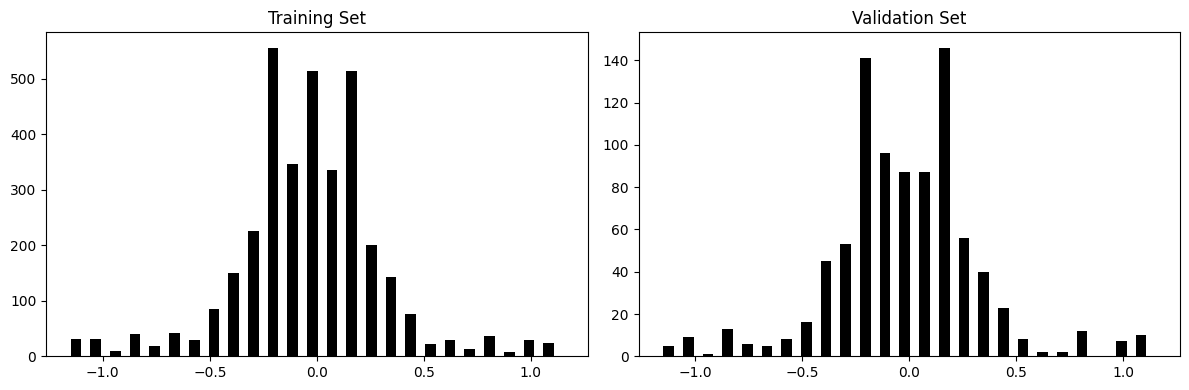

In [12]:
# checking the normalizability of train and validation datasets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot histogram for the training set
axes[0].hist(y_train, bins=bin_count, width=0.05, color='black')
axes[0].set_title('Training Set')

# Plot histogram for the validation set
axes[1].hist(y_valid, bins=bin_count, width=0.05, color='black')
axes[1].set_title('Validation Set')

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
# preprocessing the images
def image_preprocess(image):
    cropped_img = image[60:135, :, :]
    yuv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2YUV)
    blurred_img = cv2.GaussianBlur(yuv_img, (3, 3), 0)
    resized_img = cv2.resize(blurred_img, (200, 66))
    normalized_img = resized_img / 255.0

    return normalized_img

In [14]:
# getting GPU details
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [15]:
# defining some image augmentation functions

# Function to apply panning augmentation
def pan(image):
    pan_aug = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    return pan_aug.augment_image(image)

# Function to apply zoom augmentation
def zoom(image):
    zoom_aug = iaa.Affine(scale=(1, 1.3))
    return zoom_aug.augment_image(image)

# Function to apply random brightness augmentation
def random_brightness(image):
    brightness_aug = iaa.Multiply((0.2, 1.2))
    return brightness_aug.augment_image(image)

# Function to apply random horizontal flip and adjust steering angle
def random_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    return flipped_image, -steering_angle

# Function to apply random augmentations
def augment_image(image_path, steering_angle):
    image = mpimg.imread(image_path)

    # Randomly apply each augmentation
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)

    return image, steering_angle


In [16]:
# function to generates batches for training
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steerings = []

        for _ in range(batch_size):
            index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[index]
            steering_angle = steering_angles[index]

            if is_training:
                image, steering = augment_image(image_path, steering_angle)
            else:
                image = mpimg.imread(image_path)
                steering = steering_angle

            processed_image = image_preprocess(image)
            batch_images.append(processed_image)
            batch_steerings.append(steering)

        yield np.array(batch_images), np.array(batch_steerings)

In [17]:
# integrating the nvidia_model for the prediction
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))

  # adding layers into the model
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))

  # compiling the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [18]:
# getting model summary
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 18, 64)           │          76,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# training the model
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - loss: 0.3163 - val_loss: 0.0639
Epoch 2/10
168/300 ━━━━━━━━━━━━━━━━━━━━ 2:12 1s/step - loss: 0.0730

KeyboardInterrupt: 

In [ ]:
# saving the model
model.save('model_best.pickel')
from google.colab import files
files.download('model_best.pickel')